In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from taln.taln_aln import align_ng, tokenize

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax
fsize = 20
plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
DATA_DIR = (Path("..").resolve() / "data")

def short_hash(s: str) -> str:
    import hashlib

    return hashlib.sha256(s.encode()).hexdigest()[:12]


def ablate_token_target(target, pair_id, seed=3):
    tokens, _ = tokenize(target, "token")
    if len(tokens) < 3:
        raise ValueError("need at least 3 subword tokens to ablate interior")

    # deterministic per-pair ablation
    rng = random.Random(seed ^ int(pair_id, 16))
    ablidx = rng.randint(1, len(tokens) - 2)

    kept = tokens[:ablidx] + tokens[ablidx + 1 :]
    ablated = "".join([t["token"] for t in kept])

    return ablated, ablidx


def load_boat():
    tdf = pd.concat(
        [
            pd.read_json(DATA_DIR / "boat_train.tdf.json", orient="records"),
            pd.read_json(DATA_DIR / "boat_dev.tdf.json", orient="records"),
        ],
        ignore_index=True,
    )

    # idx_start stored as JSON list
    tdf["idx_start"] = tdf["idx_start"].apply(set)

    # enforce the same filter used in benchmark/ablate notebooks
    tdf = tdf[tdf["target"].str.split().str.len() > 2].reset_index(drop=True)

    # stable ordering for deterministic ablation
    tdf["pair_id"] = (tdf["source"] + "\n---\n" + tdf["target"].str.strip()).apply(short_hash)
    tdf = tdf.sort_values("pair_id").reset_index(drop=True)

    return tdf[["pair_id", "source", "target", "idx_start"]]


def get_alignments(df, target_col = "target", ttype="token"):
    rows = []
    n_alignments = []

    for r in df.itertuples(index=False):
        target = getattr(r, target_col)
        alns = align_ng(r.source, target, ttype)
        n_alignments.append(len(alns))

        for j, aln in enumerate(alns):
            rows.append(
                {
                    "pair_id": r.pair_id,
                    "source": r.source,
                    "target": target,
                    "alignment_id": j,
                    "alignment": aln,
                }
            )

    return pd.DataFrame(rows), pd.Series(n_alignments, name="n_alignments")


In [4]:
boat = load_boat()


In [5]:
tgt = ' "oneness" or "uniqueness"'
src = ' "oneness" or "uniqueness")'
align_ng(src, tgt)

[]

## Contiguous alignment

In [6]:
# contiguous dataset: enumerate all order-preserving subword alignments
contig, n_contig = get_alignments(boat, target_col = "target", ttype="token")
contig_ok = n_contig > 0
n_miss = int((~contig_ok).sum())
print(f"contig: {n_miss} / {n_contig.shape[0]} pairs had 0 subword-token alignments")

contig: 159 / 35080 pairs had 0 subword-token alignments


In [7]:
contig.shape, n_contig.describe()

((293131, 5),
 count    35080.000000
 mean         8.356072
 std        163.155444
 min          0.000000
 25%          1.000000
 50%          1.000000
 75%          4.000000
 max      19004.000000
 Name: n_alignments, dtype: float64)

## Non-contiguous alignment

In [8]:
boat_nontig = boat.copy()

boat_nontig[["ablate_target", "ablate_idx"]] = boat_nontig.apply(
    lambda r: pd.Series(ablate_token_target(r.target, r.pair_id, seed=3)),
    axis=1,
)

nontig, n_noncontig = get_alignments(boat_nontig, target_col="ablate_target", ttype="token")
miss = int((n_noncontig == 0).sum())
print(f"noncontig: {miss} / {n_noncontig.shape[0]} pairs had 0 alignments")

noncontig: 198 / 35080 pairs had 0 alignments


In [9]:
nontig.shape, n_noncontig.describe()

((243295, 5),
 count    35080.000000
 mean         6.935433
 std        145.580959
 min          0.000000
 25%          1.000000
 50%          1.000000
 75%          3.000000
 max      24244.000000
 Name: n_alignments, dtype: float64)

In [10]:
def multimap_table(n_alignments):
    s = n_alignments
    return pd.Series(
        {
            "n_pairs": int(s.shape[0]),
            "n_multimap": int((s > 1).sum()),
            "frac_multimap": float((s > 1).mean()),
            "max_alignments": int(s.max()),
            "mean_alignments": float(s.mean()),
            "median_alignments": float(s.median()),
        }
    )




summary = pd.DataFrame(
    {
        "contiguous": multimap_table(n_contig),
        "noncontiguous": multimap_table(n_noncontig),
    }
).T

summary["n_pairs_total"] = [int(n_contig.shape[0]), int(n_noncontig.shape[0])]
summary["n_pairs_zero_align"] = [int((n_contig == 0).sum()), int((n_noncontig == 0).sum())]
summary["frac_pairs_zero_align"] = [float((n_contig == 0).mean()), float((n_noncontig == 0).mean())]
summary


,n_pairs,n_multimap,frac_multimap,max_alignments,mean_alignments,median_alignments,n_pairs_total,n_pairs_zero_align,frac_pairs_zero_align
contiguous,35080.0,15108.0,0.430673,19004.0,8.356072,1.0,35080,159,0.004532
noncontiguous,35080.0,15101.0,0.430473,24244.0,6.935433,1.0,35080,198,0.005644


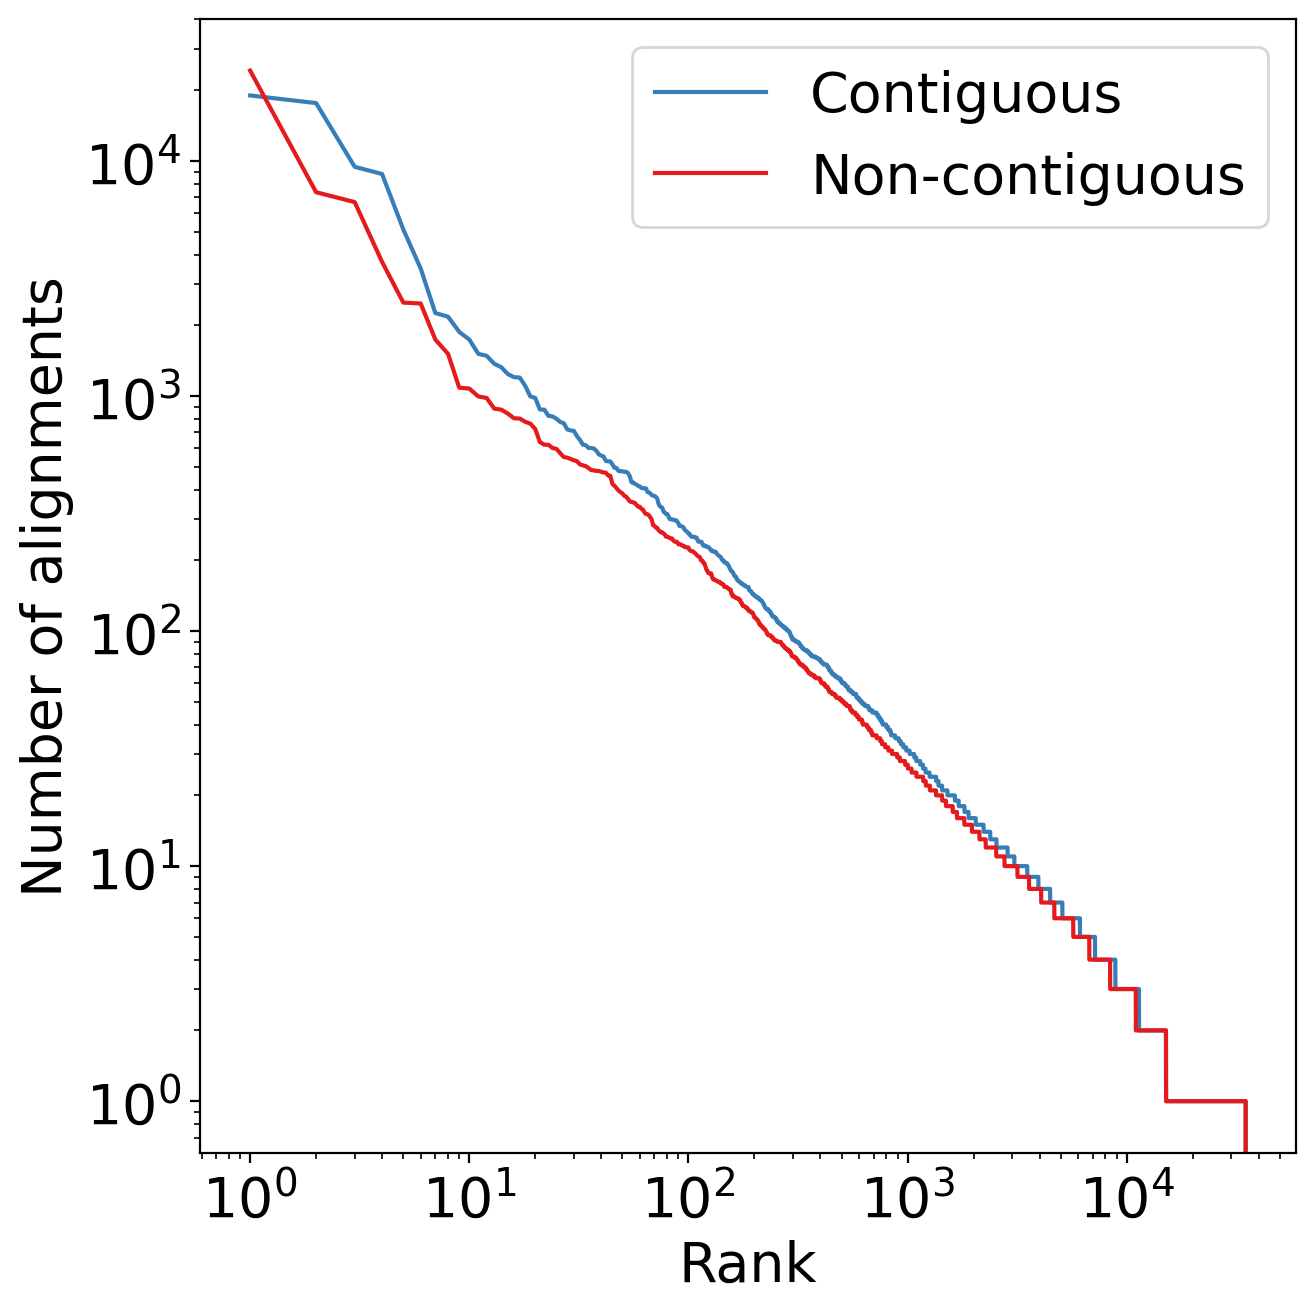

In [29]:
fig, ax = plt.subplots(figsize=(7, 7))

# For a reverse CDF, we sort descending and plot rank vs. value
def plot_reverse_cdf(data, label, color):
    values = np.sort(np.asarray(data))[::-1]  # descending
    ranks = np.arange(1, len(values) + 1)
    ax.plot(ranks, values, label=label, color=color)

plot_reverse_cdf(n_contig, "Contiguous", "#377eb8")
plot_reverse_cdf(n_noncontig, "Non-contiguous", "#e41a1c")

ax.set(
    xlabel="Rank",
    ylabel="Number of alignments",
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.tight_layout()
plt.show()


In [30]:
def write_alignment_rows(df, out_path):
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(df.to_dict(orient="records"), f)

    return str(out_path)


out_contig = write_alignment_rows(contig, DATA_DIR / "boat_contiguous.taln.json")
out_noncontig = write_alignment_rows(nontig, DATA_DIR / "boat_noncontiguous.taln.json")


def jsonable_idx_start(df):
    out = df.copy()
    if "idx_start" in out.columns:
        out["idx_start"] = out["idx_start"].apply(lambda x: sorted(list(x)) if isinstance(x, set) else x)
    return out


# write 0-alignment pairs for documentation
contig_zero = jsonable_idx_start(boat.loc[n_contig == 0]).to_dict(orient="records")
noncontig_zero = jsonable_idx_start(
    boat_nontig.loc[n_noncontig == 0][["pair_id", "source", "target", "idx_start", "ablate_target", "ablate_idx"]]
).to_dict(orient="records")

out_contig_zero = str(DATA_DIR / "boat_contiguous.naln.json")
out_noncontig_zero = str(DATA_DIR / "boat_noncontiguous.naln.json")

with open(out_contig_zero, "w", encoding="utf-8") as f:
    json.dump(contig_zero, f)

with open(out_noncontig_zero, "w", encoding="utf-8") as f:
    json.dump(noncontig_zero, f)

out_contig, out_noncontig, out_contig_zero, out_noncontig_zero


('/Users/sinabooeshaghi/projects/taln/data/boat_contiguous.taln.json',
 '/Users/sinabooeshaghi/projects/taln/data/boat_noncontiguous.taln.json',
 '/Users/sinabooeshaghi/projects/taln/data/boat_contiguous.naln.json',
 '/Users/sinabooeshaghi/projects/taln/data/boat_noncontiguous.naln.json')

In [16]:
def ws_len(s):
    return len(str(s).split())


def tok_len(s, ttype="token"):
    toks, _ = tokenize(str(s), ttype)
    return len(toks)


def summarize_pairs(df, n_align, target_col):
    n_align = pd.Series(n_align).reset_index(drop=True)

    src = df["source"]
    tgt = df[target_col]

    return {
        "n_pairs": int(df.shape[0]),
        "n_zero_align_tok": float((n_align == 0).sum()),
        "mean_align_tok": float(n_align[n_align > 0].mean()),
        "mean_source_chars": float(src.str.len().mean()),
        "mean_source_ws": float(src.apply(ws_len).mean()),
        "mean_source_tok": float(src.apply(tok_len).mean()),
        "mean_target_chars": float(tgt.str.len().mean()),
        "mean_target_ws": float(tgt.apply(ws_len).mean()),
        "mean_target_tok": float(tgt.apply(tok_len).mean()),
    }


tbl = pd.DataFrame(
    {
        "contiguous": summarize_pairs(boat, n_contig, target_col="target"),
        "noncontiguous": summarize_pairs(boat_nontig, n_noncontig, target_col="ablate_target"),
    }
).T

cols = [
    "n_pairs",
    "n_zero_align_tok",
    "mean_align_tok",
    "mean_source_chars",
    "mean_source_ws",
    "mean_source_tok",
    "mean_target_chars",
    "mean_target_ws",
    "mean_target_tok",
]

tbl = tbl[cols]

display(
    tbl.round(
        {
            "n_pairs": 0,
            "n_zero_align_tok": 4,
            "mean_align_tok": 3,
            "mean_source_chars": 1,
            "mean_source_ws": 1,
            "mean_source_tok": 1,
            "mean_target_chars": 1,
            "mean_target_ws": 1,
            "mean_target_tok": 1,
        }
    )
)

print(tbl.to_latex(float_format=lambda x: f"{x:.3f}"))


,n_pairs,n_zero_align_tok,mean_align_tok,mean_source_chars,mean_source_ws,mean_source_tok,mean_target_chars,mean_target_ws,mean_target_tok
contiguous,35080.0,159.0,8.394,764.7,121.0,157.6,37.9,5.9,7.6
noncontiguous,35080.0,198.0,6.975,764.7,121.0,157.6,33.0,5.1,6.5


\begin{tabular}{lrrrrrrrrr}
\toprule
 & n_pairs & n_zero_align_tok & mean_align_tok & mean_source_chars & mean_source_ws & mean_source_tok & mean_target_chars & mean_target_ws & mean_target_tok \\
\midrule
contiguous & 35080.000 & 159.000 & 8.394 & 764.662 & 120.989 & 157.604 & 37.947 & 5.857 & 7.573 \\
noncontiguous & 35080.000 & 198.000 & 6.975 & 764.662 & 120.989 & 157.604 & 32.965 & 5.061 & 6.542 \\
\bottomrule
\end{tabular}

